<img src="images/RIINBRE-Logo.jpg" width="400" height="400"><img src="images/MIC_Logo.png" width="600" height="600">

# Analysis of Biomedical Data for Biomarker Discovery
## Submodule 9: Biomarker Discovery Using Machine Learning
### Dr. Christopher L. Hemme
### Director, [RI-INBRE Molecular Informatics Core](https://web.uri.edu/riinbre/mic/)
### The University of Rhode Island College of Pharmacy
Last Updated: March 17, 2023

---

## Introduction

The public view of machine learning (influenced by Hollywood) is that of rogue artificial intelligence running wild and causing chaos.  If you watch the news, it sometimes seems like this is true in real life.  In most cases though, machine learning is simply a way to improve the efficiency of completing some set of tasks.  Several of the methods we've covered in this module - linear regression, logistic regression, principal components analysis, k-means clustering - are used in many machine learning algorithms.  The main difference between how we've used those methods previously is that in machine learning, we are taking advantage of the predictive properties of the methods to map new data to existing data to identify patterns in new data.

It can sometimes be difficult to decipher the different buzzwords associated with the field.  Specifically, people are often confused by the terms <b>artificial intelligence (AI)</b>, <b>machine learning (ML)</b>, and <b>deep learning (DL)</b>.  AI is a broad umbrella term that simply means algorithms that can simulate some level of human intelligence, usually for performing some task such as pattern recognition.  ML is a subset of AI that specializes in algorithms that are capable of learning without being explicitly programmed.  DL is a subset of ML that specifically tries to mimic the processes of the human brain to identify and classify patterns in large data sets.  We will focus on simple ML for this submodule.

There are several strategies used in ML, but the two most common are <b>supervised</b> and <b>unsupervised learning</b>.  In supervised learning, we use a subset of labeled data to create a training set to train our algorithm, which can then process new data based on the training set.  In unsupervised learning, the algorithm is attempting to identify new patterns or structures in unlabeled data.

Some examples of how ML is currently or will be used in biomedical science include:

- Diagnose a patient's disease severity based on their tissue proteomics profile
- Predict an individual's susceptibility to disease based on their pattern of genetic variations
- Solve the three-dimensional structure of an unknown protein based on its sequence
- Identify approved drugs which can be repurposed to treat diseases based on chemical structure and omics profiles

In this module we will use some basic ML algorithms to analyze the IRI proteomics data we've previously analyzed.

<div class="alert alert-block alert-info">
<b>&#9995; Tip:</b> Blue boxes will indicate helpful tips.</div>

<div class="alert alert-block alert-warning">
<b>&#127891; Note:</b> Used for interesting asides or notes.
</div>

<div class="alert alert-block alert-success">
<b>&#9997; Reference:</b> This box indicates a reference for an attached figure or table.
</div>

<div class="alert alert-block alert-danger">
<b>&#128721; Caution:</b> A red box indicates potential hazards or pitfalls you may encounter.
</div>

## Load the libraries

This notebook creates a basic template for running a machine learning project in R. 

In [1]:
# Install packages
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
library('BiocManager')

bioc_packages <- c("limma", "ComplexHeatmap", "M3C")
installed_bioc_packages <- bioc_packages %in% rownames(installed.packages())
if (any(installed_bioc_packages == FALSE)) {BiocManager::install(bioc_packages[!installed_bioc_packages])}

BiocManager::install("preprocessCore")
BiocManager::install("preprocessCore", configure.args="--disable-threading", force = TRUE)

packages <- c("caret", "randomForest", "kernlab", "ggraph", "rattle", "gbm")
installed_packages <- packages %in% rownames(installed.packages())
if (any(installed_packages == FALSE)) {install.packages(packages[!installed_packages])}

if(!require(devtools)) install.packages("devtools")
devtools::install_github("kassambara/factoextra")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

Bioconductor version 3.16 (BiocManager 1.30.20), R 4.2.3 (2023-03-15)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'preprocessCore'”
Installation paths not writeable, unable to update packages
  path: /usr/lib/R/library
  packages:
    survival

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

Bioconductor version 3.16 (BiocManager 1.30.20), R 4.2.3 (2023-03-15)

Installing package(s) 'preprocessCore'

Installation paths not writeable, unable to update packages
  path: /usr/lib/R/library
  packages:
    survival

Installing packages into ‘/home/jupyter/.R/library’
(a

In [2]:
# Load the packages
require('preprocessCore')
require('limma')
require('ComplexHeatmap')
require('plyr')
require('tidyverse')
require('factoextra')
require('caret')
require('kernlab')
require('ggpubr')
require('rattle')
require('dplyr')
require('ggraph')
require('igraph')
require('ggplot2')
require('mlbench')
require('pROC')
require("gbm")

Loading required package: preprocessCore

Loading required package: limma

Loading required package: ComplexHeatmap

Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Loading required package: plyr

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ d

## Load the proteome data and merge with the metadata

We will be loading our experimental object from <b>Submodule07 - Exploratory Proteomic Analysis</b> since it already has our proteomic data merged with our metadata and has been normalized.

In [3]:
exp_obj <- readRDS(file = "data/Saved_Data/exp_obj.rds")

<div class="alert alert-block alert-danger">
<b>&#128721; Caution:</b> Reminder that this version of the experimental object should contain the quantile normalized data from submodule 4.  Use <i>str(exp_obj)</i> if you need to verify that this is the case. 
</div>

In [4]:
# Read in the normalized data from Submodule 4
proteome_norm <- exp_obj$data$proteomics$norm
metadata <- exp_obj$metadata
head(metadata)

Sample,Treatment,Time,Batch
<chr>,<fct>,<fct>,<fct>
LK83.1,CTRL,0,2
LK83.2,CTRL,0,2
LK83.3,CTRL,0,2
LK83.4,CTRL,0,2
LK83.5,CTRL,0,2
X83.6,CTRL,0,1


In [5]:
head(proteome_norm)

,LK83.1,LK83.2,LK83.3,LK83.4,LK83.5,X83.6,Control1,Control2,X05.1,X05.2,⋯,X13.5,X55.1,X55.2,X61.2,X61.1,X19.2,X19.5,X71.1,X71.2,X71.4
;Ddx21,-2.6727507,-2.1901850,-2.2421496,-2.5998268,-2.301827,-2.5834750,-2.4167815,-2.7997399,-2.87909105,-2.6346873,⋯,-0.8813137,-1.4257912,-0.9542488,-1.3635716,-1.7654583,-1.895894,-2.0458740,-1.3325472,-1.21081692,-0.9302010
;Dut,1.3352930,1.2189122,1.0112785,1.2167170,1.143424,1.3177368,1.5065033,1.3638557,1.35677411,1.4808844,⋯,0.8834256,1.2554022,1.6140508,1.3004754,1.1461517,1.100273,0.8182732,1.2146009,1.27887874,1.4912903
;Eno1,6.6852294,6.7366109,6.6587706,6.5799006,6.765378,7.0505327,6.9041000,7.0851305,6.84793209,6.7123751,⋯,6.6587706,6.7123751,6.7653779,6.7366109,6.5357016,6.736611,6.5799006,6.8752445,6.63468865,6.4776125
;Hist2h2aa3,8.7459919,8.7459919,8.6142455,8.7459919,8.388745,8.3105865,7.7462550,7.5541497,7.33375498,7.5541497,⋯,8.9806716,8.7459919,8.9806716,8.9806716,8.7459919,9.956039,9.9560393,9.3543257,10.39987193,9.9560393
;LOC108349606;Rpl7a,3.0713768,2.8954008,2.9075111,3.1356851,2.295193,0.3704181,-0.1695525,-0.3840378,0.90063784,0.6645827,⋯,3.7794672,2.9816773,1.5106105,1.6160616,3.1392418,3.728905,3.6666072,2.5993958,2.05298796,2.6574290
;RGD1564138;;Rpl29,0.7549548,0.5360638,0.1302277,0.8598805,-0.190857,0.1492028,-2.0770394,-2.3909583,0.01573162,0.6548808,⋯,1.7940819,0.7752549,-0.8205572,-0.1583842,0.4334262,1.585295,1.7964252,0.3843435,-0.06170927,0.9387404


Next we will transpose the normalized protein data so that it is in the same orientation as the metadata file. That way we can add metadata columns directly to the data frame. We'll make a new data frame so we don't corrupt the original proteome_norm.

In [6]:
t_proteome = as.data.frame(t(proteome_norm))
head(t_proteome)

,;Ddx21,;Dut,;Eno1,;Hist2h2aa3,;LOC108349606;Rpl7a,;RGD1564138;;Rpl29,;Rpl35a,A1cf,A1i3,A1m,⋯,Ywhag,Ywhah,Ywhaq,Ywhaz,Zadh2,Zbed5;LOC100911516,Zbtb20,Zmpste24,Zyx,ifitm3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LK83.1,-2.672751,1.335293,6.685229,8.745992,3.0713768,0.7549548,4.856959,-1.321307,1.779781,2.232800,⋯,6.535702,2.344344,3.335693,4.864637,0.7752549,0.4734643,-1.782838,0.3398078,-1.1065994,2.163799
LK83.2,-2.190185,1.218912,6.736611,8.745992,2.8954008,0.5360638,4.812706,-1.068025,2.025779,2.309123,⋯,6.904100,2.675646,3.350142,4.916456,0.7818062,0.4995963,-1.832988,0.1788302,-0.6139115,2.209514
LK83.3,-2.242150,1.011278,6.658771,8.614245,2.9075111,0.1302277,4.752918,-1.379271,2.355510,2.952767,⋯,7.333755,2.950009,3.467302,4.992097,0.6298663,0.2235891,-1.915093,0.4294220,-0.8124255,2.260600
LK83.4,-2.599827,1.216717,6.579901,8.745992,3.1356851,0.8598805,4.895619,-1.450267,2.548711,2.950009,⋯,7.221570,2.805704,3.393334,4.949957,0.8429297,0.3448727,-1.638606,0.2283276,-0.4372301,2.295193
LK83.5,-2.301827,1.143424,6.765378,8.388745,2.2951929,-0.1908570,4.427170,-1.121754,1.943265,2.484334,⋯,7.118475,2.809132,3.460236,4.984634,0.8894642,0.6060125,-1.790425,0.4142121,-0.4863469,2.145656
X83.6,-2.583475,1.317737,7.050533,8.310586,0.3704181,0.1492028,3.335693,-1.645564,3.353291,2.780315,⋯,6.408419,2.487435,3.531192,5.357232,0.9739843,0.8160086,-2.136888,0.6477696,0.3751295,3.142188


## Define Injury States for Machine Learning

Remember that supervised machine learning involves splitting the dataset into training and testing sets. In order to do supervised machine learning, we need to have an outcome to train the algorithm to predict, in this case, predicting injury state from IRI proteomics data. We will define a sample as injured if it has a SCr concentration above a critical threshold, whereas any sample with a SCr below that will be considered healthy. As we did in <b>Submodule 6: Linear and Logistic Regression for Comparison of Quantitative Biomarkers</b>, we will use the clinically established value of SCr >= 1.  

In the code block below, we end up with a cohort that has approximately 3 times as many healthy samples as injured samples. Class imbalances like this are common in machine learning and especially exaggerated in bioinformatics. We will have to account for this when we build our models.

Just as we did before in <b>Submodule06 - Linear and Logistic Regression Biomarkers</b> we will create a new column labeled **'D'** and give a value to each sample depending on whether SCr levels are greater than 1 but instead of giving 1 and 0 values we will use the terms Healthy vs. Injured.

<div class="alert alert-block alert-info">
<b>&#9995; Tip:</b> In a real-world machine learning scenario, defining labels is often a painstaking process that must be done in conjunction with subject matter experts and frequently involves a prolonged back-and-forth process between the team that generated the data and the analysis team.
</div>

<div class="alert alert-block alert-warning">
<b>&#127891; Note:</b> Some of the machine learning code may take several minutes to run.
</div>

In [7]:
# Add SCR/BUN data to the metadata frame
biomarkers = read.csv("data/Renal_IRI_Proteomics/IRI_Biomarkers.csv")
sample_data = cbind.data.frame(metadata,biomarkers)

# Summary statistics
summary(sample_data)

# Define constant normal values for SCR and BUN
SCR = 1

# Define injury state based on SCR. Since BUN has so many missing values, we will only use SCR. if SCR is greater than 1 label Injured
injury = ifelse((sample_data$SCr > SCR),"Injured","Healthy")
table(injury)
sample_data$D = injury

    Sample          Treatment Time    Batch     Sample         
 Length:96          CTRL: 8   0 : 8   2:62   Length:96         
 Class :character   SHAM:25   1 :16   1:34   Class :character  
 Mode  :character   PLB :33   3 :15          Mode  :character  
                    TRE :30   6 :20                            
                              24:22                            
                              48:15                            
                                                               
      SCr              BUN        
 Min.   :0.1580   Min.   : 21.33  
 1st Qu.:0.4093   1st Qu.: 34.12  
 Median :0.6520   Median : 59.12  
 Mean   :0.7645   Mean   : 72.07  
 3rd Qu.:1.0265   3rd Qu.: 90.80  
 Max.   :2.9180   Max.   :243.50  
                  NA's   :43      

injury
Healthy Injured 
     70      26 

In [8]:
# Add the Injured outcome label to the proteomics data frame for training

t_proteome$D = factor(sample_data$D)
head(t_proteome)

,;Ddx21,;Dut,;Eno1,;Hist2h2aa3,;LOC108349606;Rpl7a,;RGD1564138;;Rpl29,;Rpl35a,A1cf,A1i3,A1m,⋯,Ywhah,Ywhaq,Ywhaz,Zadh2,Zbed5;LOC100911516,Zbtb20,Zmpste24,Zyx,ifitm3,D
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
LK83.1,-2.672751,1.335293,6.685229,8.745992,3.0713768,0.7549548,4.856959,-1.321307,1.779781,2.232800,⋯,2.344344,3.335693,4.864637,0.7752549,0.4734643,-1.782838,0.3398078,-1.1065994,2.163799,Healthy
LK83.2,-2.190185,1.218912,6.736611,8.745992,2.8954008,0.5360638,4.812706,-1.068025,2.025779,2.309123,⋯,2.675646,3.350142,4.916456,0.7818062,0.4995963,-1.832988,0.1788302,-0.6139115,2.209514,Healthy
LK83.3,-2.242150,1.011278,6.658771,8.614245,2.9075111,0.1302277,4.752918,-1.379271,2.355510,2.952767,⋯,2.950009,3.467302,4.992097,0.6298663,0.2235891,-1.915093,0.4294220,-0.8124255,2.260600,Healthy
LK83.4,-2.599827,1.216717,6.579901,8.745992,3.1356851,0.8598805,4.895619,-1.450267,2.548711,2.950009,⋯,2.805704,3.393334,4.949957,0.8429297,0.3448727,-1.638606,0.2283276,-0.4372301,2.295193,Healthy
LK83.5,-2.301827,1.143424,6.765378,8.388745,2.2951929,-0.1908570,4.427170,-1.121754,1.943265,2.484334,⋯,2.809132,3.460236,4.984634,0.8894642,0.6060125,-1.790425,0.4142121,-0.4863469,2.145656,Healthy
X83.6,-2.583475,1.317737,7.050533,8.310586,0.3704181,0.1492028,3.335693,-1.645564,3.353291,2.780315,⋯,2.487435,3.531192,5.357232,0.9739843,0.8160086,-2.136888,0.6477696,0.3751295,3.142188,Healthy


## Preprocess and train/test split

One of the core concepts of machine learning is the splitting of data into training and test sets. The training dataset is used to build the model and contains the data itself (proteomics counts in this example) and a set of labels (injury state). The model iterates over the training data, learning the relationships between the input data and output labels. Once the model is trained its predictive ability is evaluated using the test dataset. The test dataset should be data that the model has never seen before but that has come from the same distribution as the training data.

We will split the data into training and test datasets comprised of 80% and 20% of the original data, respectively. The **caret** package provides functionality to do this with the **createDataPartition** function. As machine learning becomes increasingly widely adopted, the ML packages in both R and Python have developed cutting edge helper functions like this, and using them for train/test splitting is a best practice that is highly preferable to hard-coding the split with base R commands.

One benefit of using **createDataPartition** is that it automatically handles class imbalances when splitting on a categorical variable. Remember earlier when we said we had many more healthy samples than injury samples? **createDataPartition** recognizes this and makes sure that the training set has roughly the same ratio of healthy:injured as the training set does.  Class imbalances can still affect model performance. If the class you are trying to predict is a rare event, the model can learn that to improve accuracy.  It's best to assign most predictions to the class that makes up the majority of the data it was trained on. One way to handle this is random oversampling for class imbalance which we'll explore later. 

In [9]:
# Set the seed so that we end up with the same split each time we run this.
set.seed(3456)

# Split the data based on the variable D.
trainIndex <- createDataPartition(t_proteome$D, p = .8, 
                                  list = FALSE, 
                                  times = 1)

# The output is the indices of samples in the training set
head(trainIndex)

Resample1
1
2
4
5
6
7


In [10]:
# Define training and testing as data frames
training = t_proteome[trainIndex,]
testing = t_proteome[-trainIndex,]
dim(training)

[1]   77 2364

## Feature selection

It is not feasible to use every protein in our proteomics screening as a feature in the model. Remember that omics datasets are usually sparse, meaning many of the features  will have low information across samples and will be unhelpful for distinguishing injury from healthy samples. Additionally, from a logistical perspective, it is not reasonable to put several thousand proteins into a laboratory test to use for classification in a real-world setting. With that in mind, we need to find the top features that contain the most information and use those top proteins as variables in the model, as opposed to thousands or tens of thousands that can be measured in a typical mass spectrometry experiment. 

It is important to do this feature selection process on the training set and not the full dataset, otherwise it will bias the features based on information in the test set, which your model and features should not see until model evaluation called 'test leakage'. 

In the code block below, we will build a random forest model using all of the features and rank the features based on their impact on the model's accuracy. This will give us a basis from which to include/exclude features in the training set going forward. We will learn about random forest models and the settings below in more detail soon.

In [11]:
fitControl_randomforest <- trainControl(# 10-fold cross-validation (CV)
                           method = "repeatedcv",
                           number = 10,
                           # Repeated ten times
                           repeats = 10)

# Build random forest from full dataset
set.seed(123)
# mtry hyperparameter is tuned, ntree is not
mtry <- sqrt(ncol(training))
tunegrid <- expand.grid(.mtry=mtry)
rf_full <- train(D~., 
                      data=training, 
                      method='rf', 
                      metric='Accuracy', 
                      tuneGrid=tunegrid, 
                      trControl=fitControl_randomforest)
print(rf_full)

Random Forest 

  77 samples
2363 predictors
   2 classes: 'Healthy', 'Injured' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 69, 69, 70, 70, 69, 70, ... 
Resampling results:

  Accuracy   Kappa    
  0.7344643  0.1338864

Tuning parameter 'mtry' was held constant at a value of 48.62098


Listing the important variables with `varImp` can help us see what the top 100 important features are. We can narrow the list further to show only the top 30 important features.

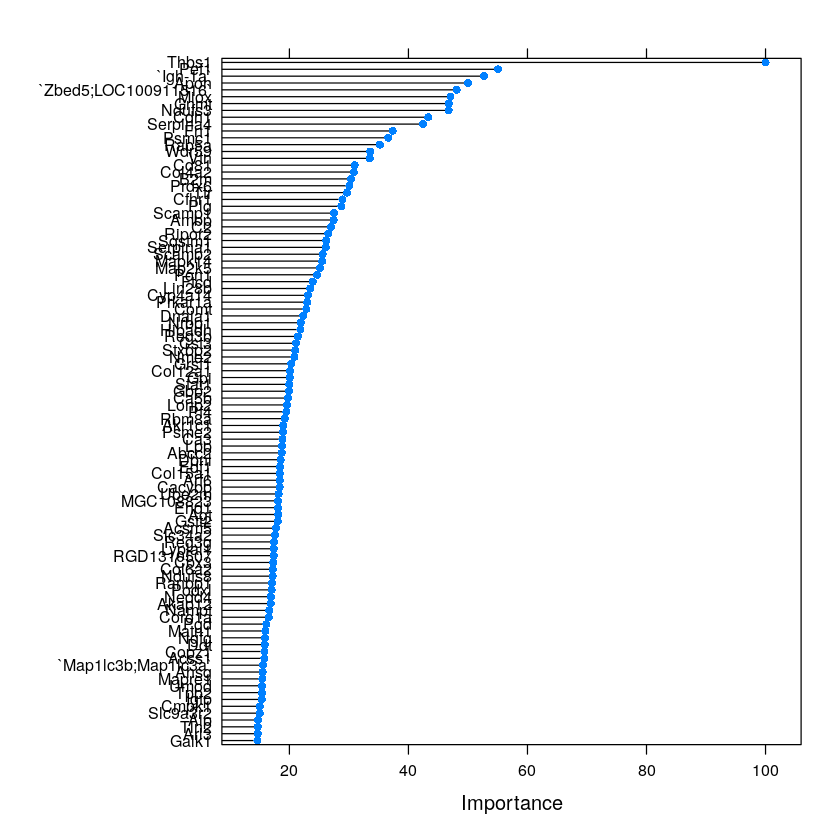

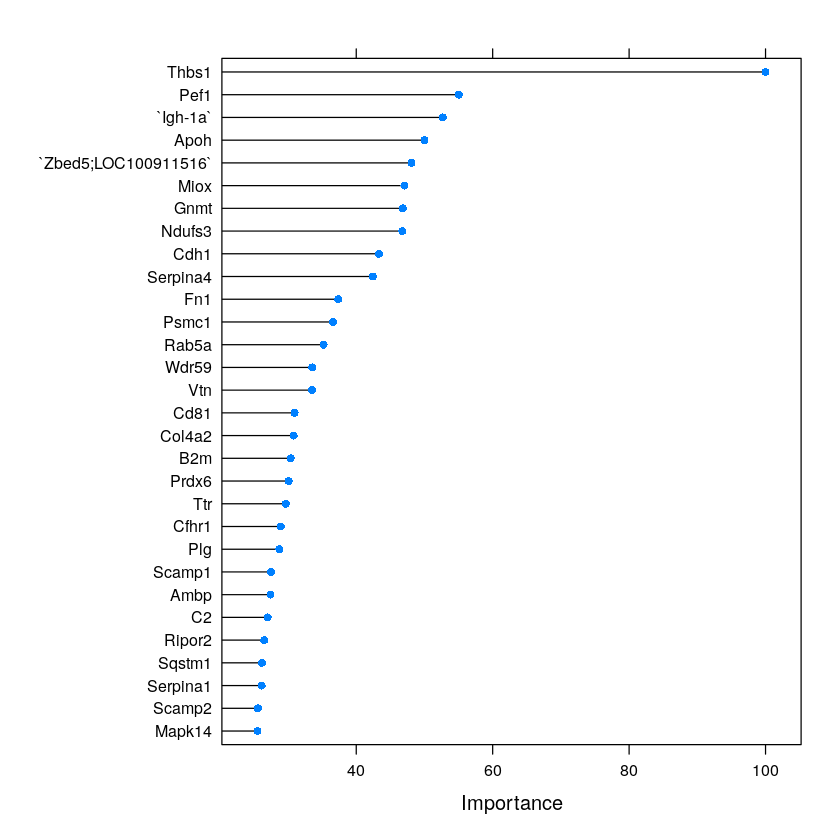

In [12]:
rfImp = varImp(rf_full)
par(pty = "m")
# Plot the top 100 proteins and top 30 proteins
top100 <- plot(rfImp, top = 100)
top30 <- plot(rfImp, top = 30)

top100
top30

We can see from this plot that not all variables are equally valuable in the model. By selecting the top features, we can hopefully capture the core information that these variables encode while avoiding overfitting the model. 

Let's grab the top 30 proteins and use those to train our models.

In [13]:
nKeep = 30 # Number of features to keep

# Get the ranked importance into a dataframe
ImpMeasure=data.frame(varImp(rf_full)$importance)
ImpMeasure$Vars<-row.names(ImpMeasure)

# Sort the dataframe and extract the protein names (row names)
keepVars = rownames(ImpMeasure[order(-ImpMeasure$Overall),][1:nKeep,])
# Eliminate the ` character from the gene names since it messes with the matching step below
keepVars = gsub("`","",keepVars)

# Subset the training and test datasets to only the features being used
keep = which(colnames(training) %in% keepVars)
training = training[,c(keep,ncol(training))]
testing = testing[,c(keep,ncol(testing))]

## Train and Test by spot checking a handful of models
### Classification algorithms tested: Decision Tree, Random Forest, GBM, and SVM

In this section, we'll test our prediction with our data using different ML algorithms. It is a best practice to assess a number of algorithms appropriate for your problem. In our case, we have identified a 1:4 class imbalance and <b>decision trees</b> are typically better suited to address this scenario. We will test with three tree-based models and one non-tree-based model and compare the performance across the four classification algorithms. All of the models we will test are supervised learning models that use classification or regression methods. For all of these models we will be using the **caret** package.

In each model you'll see similar steps: 
- Set a random seed number so we have similar stats each time this notebook is run
- Set up the training procedure 
- Determine which hyperparameter(s) and which value sets to try in our training to find the best training model
- Test and make predictions with our test data
- View results

<div class="alert alert-block alert-warning">
<b>&#127891; Note:</b> Model accuracy, while intuitive and easy to understand (thus its use in the evaluations below), is not necessarily the best metric to use for imbalanced classification problems. Depending on the problem domain you may need to optimize for other measures. See <a href="https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/">https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/</a> for more information.
</div>

## Decision Tree Models

As mentioned before, a <b>Decision Tree</b> is a type of supervised machine learning (as are the rest of the models in this submodule) that is used to make a prediction when asked a direct question based on categories within the dataset.  Decision trees go through the predictor variables and continuously split the data like in the example below.  When plotted it shows a single tree or hierarchical diagram that is easy to interpret.  Some terms to remember when looking at the tree are:

- **Root node:** The base of the decision tree.
- **Splitting:** The process of dividing a node into multiple sub-nodes.
- **Decision node:** When a sub-node is further split into additional sub-nodes.
- **Leaf node:** When a sub-node does not further split into additional sub-nodes; represents possible outcomes.
- **Pruning:** The process of removing sub-nodes of a decision tree.
- **Branch:** A subsection of the decision tree consisting of multiple nodes.

<img src="images/tree-graphic.png" width="500" height="500">

<div class="alert alert-block alert-success">
<b>&#9997; Reference:</b> <a href="https://www.mastersindatascience.org/learning/machine-learning-algorithms/decision-tree/">https://www.mastersindatascience.org/learning/machine-learning-algorithms/decision-tree/</a>
</div>

As we mentioned before, decision trees can predict outcomes when asked a direct question such as "based on the following characteristics within my dataset is today more likely to be  rainy or sunny?". In our case our question would be "based on the characteristics within our dataset which biomarkers would lead to an injured or healthy sample?". As the tree goes down its branches it will ask more questions such as "does the sample also show that this biomarker is present? What is the concentration?" until it has narrowed down its decision to whether the sample is healthy or injured.

<div class="alert alert-block alert-danger">
<b>&#128721; Caution:</b> Although decision trees are great for the question we are asking they are not the best to use in large data sets or for complex questions that deal with may factors. They are also prone to overfitting and can give a low prediction accuracy rate.
</div>

## Creating a Decision Tree

Before we run our decision tree we need to set up the training procedure. In the command below we are setting a K-fold cross validation that we have set to 10 and we ask to repeat that 3 times. To understand this, think of a deck of cards as our dataset. We will be breaking our deck into 10 groups (these are our K folds).  We will train and test all sets of cards then repeat the process again another two times by shuffling our deck and again breaking the cards into 10 sets per shuffle. This will help to ensure that each iteration is different from the next which helps to avoid overfitting and helps to obtain a higher accuracy rate.

In [14]:
# Set seed so stats don't change every time this analysis is run
set.seed(825)

# Set up the training procedure or train control object, repeated Cross-Validation, that you'll refer to later in the training model
# Below you'll see we chose to do 10-fold cross-validation repeated 3 times 
train.control_dt <- trainControl(
                           method = "repeatedcv",
                           number = 10, ## 10-fold CV
                           repeats = 3,## repeated three times
                           )

Now we need to select our tuning parameter. Each model has a hyperparameter that can be tuned to optimize your model's architecture and get the highest rate of performance possible (aka greater accuracy). The major tuning parameter for decision trees is complexity parameter (cp).  This is the minimum improvement amount, i.e. how many branches can the tree make without increase relative error. Below we've set it to a range because adding too large of a value will result in a very small tree and too small of a value can result in overfitting and too many branches in the tree.

In [15]:
# Save parameters in tune grid object that you'll refer to later in the training model
tune.grid_dt <- expand.grid(cp = seq(from = 0, to = .5, by = 0.001))

Now we can finally train our model. We will be using the **rpart** function within the **caret** package to train our decision tree based on the **'D'** column within our training dataset. You can see that we have added our parameters that we created before: training procedures and setting our cp grid to gain the best accuracy rate.

In [16]:
model_train_dt <- train(D~., data = data.frame(training), 
                 method = "rpart", 
                 tuneGrid = tune.grid_dt,
                 trControl = train.control_dt,
                 metric = "Accuracy"
               )

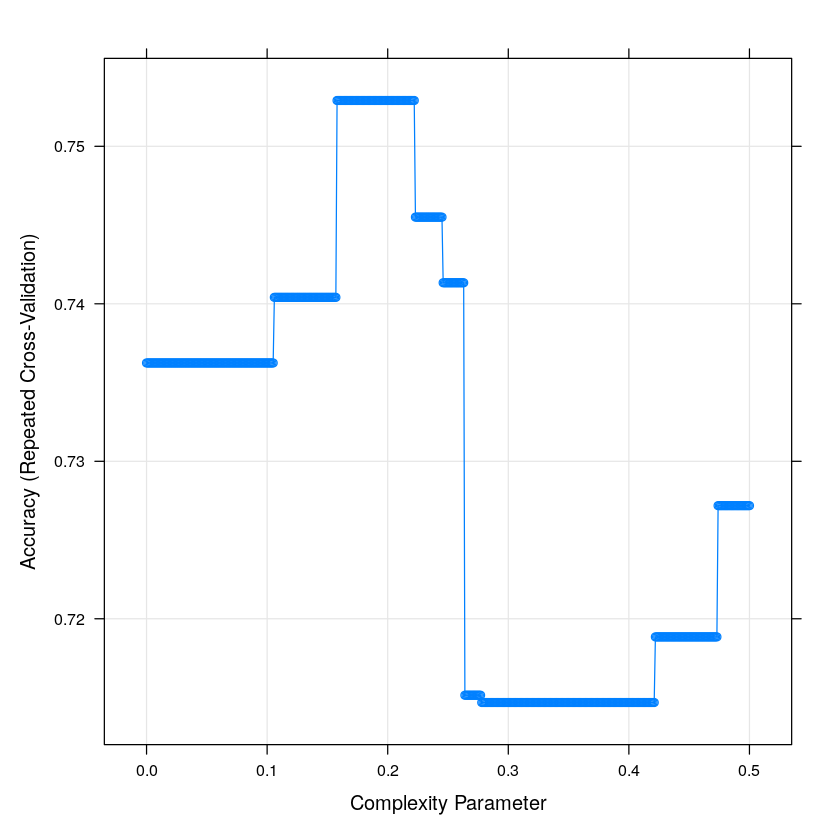

In [17]:
plot(model_train_dt)

Now we tune our model with the best tuning parameter.

In [18]:
# Show best tuning parameter from all the ones we tested
# Print the best tuning parameter cp that maximizes model accuracy
model_train_dt$bestTune

# Show the model 
model_train_dt


,cp
,<dbl>
223,0.222


CART 

77 samples
30 predictors
 2 classes: 'Healthy', 'Injured' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 70, 70, 69, 69, 69, 69, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa       
  0.000  0.7362434   0.252839343
  0.001  0.7362434   0.252839343
  0.002  0.7362434   0.252839343
  0.003  0.7362434   0.252839343
  0.004  0.7362434   0.252839343
  0.005  0.7362434   0.252839343
  0.006  0.7362434   0.252839343
  0.007  0.7362434   0.252839343
  0.008  0.7362434   0.252839343
  0.009  0.7362434   0.252839343
  0.010  0.7362434   0.252839343
  0.011  0.7362434   0.252839343
  0.012  0.7362434   0.252839343
  0.013  0.7362434   0.252839343
  0.014  0.7362434   0.252839343
  0.015  0.7362434   0.252839343
  0.016  0.7362434   0.252839343
  0.017  0.7362434   0.252839343
  0.018  0.7362434   0.252839343
  0.019  0.7362434   0.252839343
  0.020  0.7362434   0.252839343
  0.021  0.7362434   0.252839343

From our plot and the table we can see that the best cp value with the highest accuracy of 75.3% is 0.222.

We can plot our tree based on our training dataset by using the **rattle** package to add some color. Looks like it found a simple pattern, samples that have biomarkers Thbs at certain concentrations present may indicate injury. 

To explain the number within the decision nodes if the protein Thbs is present in the sample and the concentration is less than -0.52 mg/dL then there is a .73% chance that the sample is healthy. But if it has a greater concentration then there is a 27% chance the sample will be injured. The overall prediction for this biomarker has a 100% accuracy.

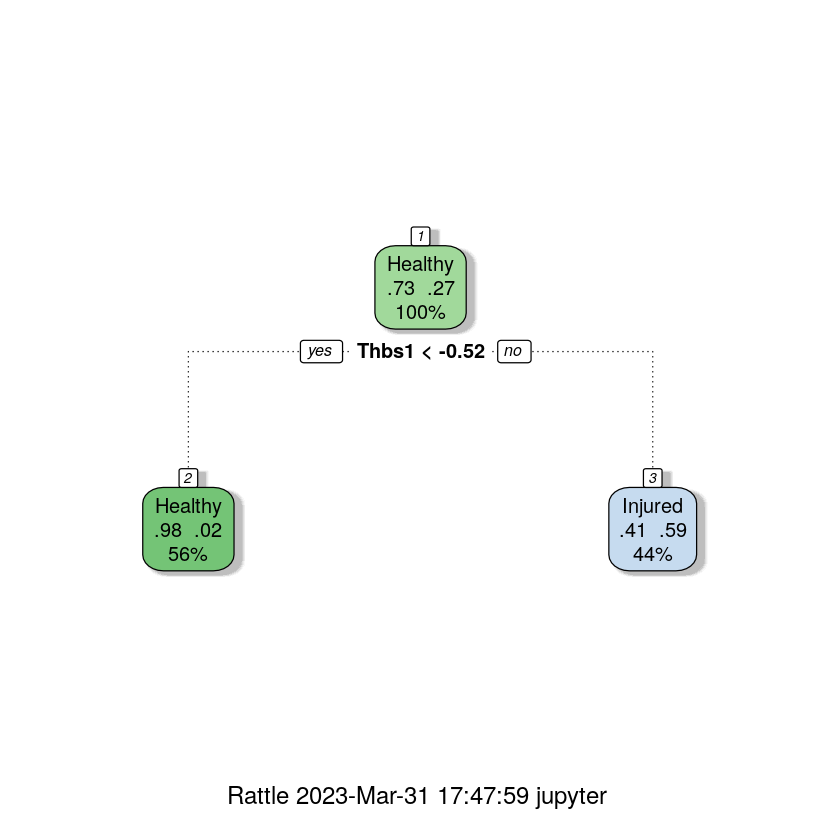

In [19]:
fancyRpartPlot(model_train_dt$finalModel)

Now we can finally test our model using the **predict** function. You will notice that we run **predict** twice.  The second time is to gather all prediction possibilities that we can later plot in our ROC/AUC curves. We will also create a <b>Confusion Matrix</b> that evaluates our models by showing us how many predictions were true positives, false positives, true negatives, and false negatives. We will go into more detail about confusion matrices towards the end of this submodule.

In [20]:
# Testing - Returns Predictions
model_test_dt <- predict(object = model_train_dt,
          newdata = data.frame(testing))
# Testing - Returns Probabilities used in ROC/AUC curves
model_test_probs_dt <- predict(object = model_train_dt,
          newdata = data.frame(testing), type = "prob")


# Print confusion matrix  
confusionMatrix(data = model_test_dt,
                  reference = testing$D,
                  positive = "Injured")

Confusion Matrix and Statistics

          Reference
Prediction Healthy Injured
   Healthy      11       1
   Injured       3       4
                                          
               Accuracy : 0.7895          
                 95% CI : (0.5443, 0.9395)
    No Information Rate : 0.7368          
    P-Value [Acc > NIR] : 0.4132          
                                          
                  Kappa : 0.519           
                                          
 Mcnemar's Test P-Value : 0.6171          
                                          
            Sensitivity : 0.8000          
            Specificity : 0.7857          
         Pos Pred Value : 0.5714          
         Neg Pred Value : 0.9167          
             Prevalence : 0.2632          
         Detection Rate : 0.2105          
   Detection Prevalence : 0.3684          
      Balanced Accuracy : 0.7929          
                                          
       'Positive' Class : Injured         
      

Our results show that our model predicted 4 Injured samples as true positive, and the overall accuracy of our model was 79%.

---

<div class="alert alert-block alert-warning">
<b>&#127891; Note:</b> The remaining models follow the same steps as the decision tree. Though they do use different methods and tuning parameters.
</div>


## Random Forest Model

<b>Random Forests</b> consists of hundreds or thousands of decision trees, each containing different outcomes or predictions. It then takes the average of these trees based on their accuracy to present the best prediction with the least amount of errors. Random forests have higher accuracy and can answer complex questions like "based on the following characteristics within my dataset will today more likely be a rainy, sunny, cloudy, or windy day?".

Random forests use **mtry** to tune their models. Since the trees are made independently from each other we need to create some randomness and thats exactly what mtry does!

In [21]:
# Set seed so stats don't change every time this analysis is run
set.seed(123)

# SELECT TUNING PARAMETERS
# The major tuning parameter for the random forest model is mtry. This determines how many predictors are used at each split.
# A common value for default is the square root of the number of predictors in software packages. 

# Define mtry values you'd like to assess
sqrt(ncol(training))

mtry <- c(4.5, sqrt(ncol(training)), 6.5, 7.5, 8.5, 9.5)
          
# Save parameters in tune grid object that you'll refer to later in the training model
tunegrid <- expand.grid(.mtry=mtry)



[1] 5.567764

<div class="alert alert-block alert-info">
<b>&#9995; Tip:</b>

If there are many relevant predictor variables, mtry should be set small so that the strongest influential variables are chosen in the splits alongside less influential variables, which can provide small but relevant performance gains. These less influential variables might, for example, be useful for the prediction of a small group of observations that stronger variables fail to predict correctly. When mtry is large less influential variables might not have the chance to contribute to prediction because stronger variables are preferably selected for splitting and thus “mask” the smaller effects. Genomics datasets often have a few relevant variables compared to many so it may be a good idea to try mtry values that are higher. Source: https://arxiv.org/pdf/1804.03515.pdf#:~:text=2.1.1%20Number%20of%20randomly,Lower%20values%20of%20mtry%20lead 
</div>

#### Random Forest Training

For random forest we are using the **rf** method from the **caret** package.

,mtry
,<dbl>
5,8.5


Random Forest 

77 samples
30 predictors
 2 classes: 'Healthy', 'Injured' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 69, 69, 70, 70, 69, 70, ... 
Resampling results across tuning parameters:

  mtry      Accuracy   Kappa    
  4.500000  0.8224868  0.4729913
  5.567764  0.8260582  0.5062039
  6.500000  0.8272487  0.5029684
  7.500000  0.8056878  0.4496172
  8.500000  0.8386905  0.5420455
  9.500000  0.8266534  0.5121310

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 8.5.

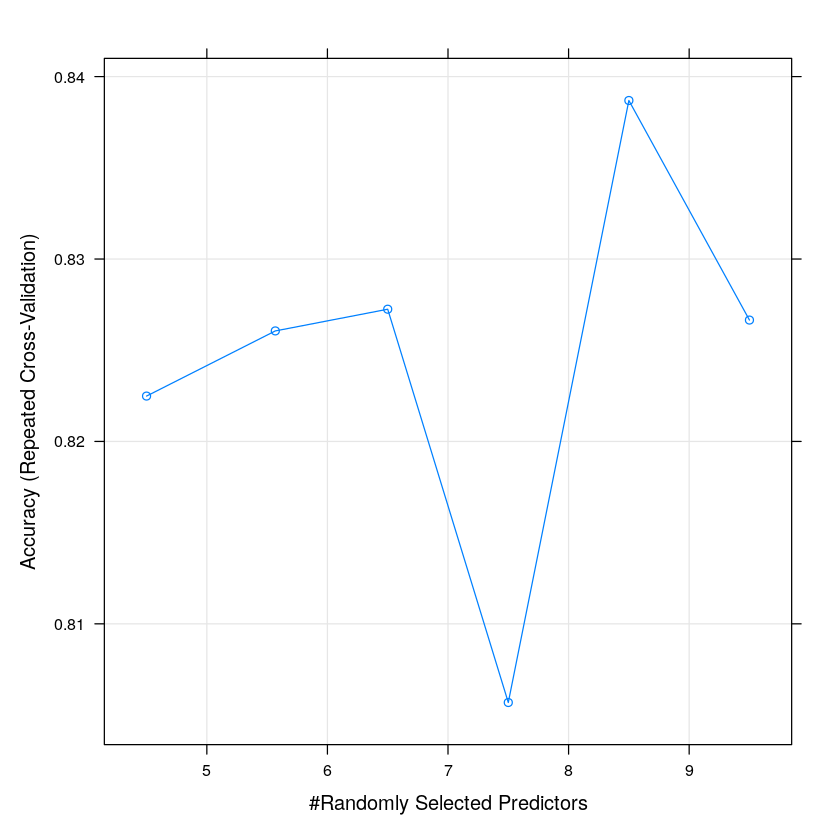

In [22]:
# Set up the training procedure or train control object, repeated Cross-Validation, that you'll refer to later in the training model
# Below you'll see we chose to do 10-fold cross-validation repeated 3 times 
train_control_rf <- trainControl(
                           method = "repeatedcv",
                           number = 10,
                           repeats = 3)

# Fit the model 
model_train_rf <- train(D~., 
                      data=training, 
                      method='rf', 
                      metric='Accuracy', 
                      tuneGrid=tunegrid, 
                      trControl=train_control_rf)

# View the model
plot(model_train_rf)

# Show best tuning parameter from all the ones we tested
# Print the best tuning parameter C that maximizes model accuracy
model_train_rf$bestTune

# Show the model 
model_train_rf

We can see from our our model and the plot that when mtry = 8.5 we get the best accuracy (83.9%).

#### Optional: Taking a Closer Look at a Random Forest

As we know random forests are made up of hundreds of decision trees.  To help understand what one of them would look like, let's plot one! 

First we need to know which tree to choose. If we plot the final model the plot shows us the average error rate of our classes (Injured vs. Healthy). We can see that 500 decision trees have been created.

,OOB,Healthy,Injured
"[495,]",0.1948052,0.07142857,0.5238095
"[496,]",0.1948052,0.07142857,0.5238095
"[497,]",0.1948052,0.07142857,0.5238095
"[498,]",0.1818182,0.07142857,0.4761905
"[499,]",0.1948052,0.07142857,0.5238095
"[500,]",0.1818182,0.07142857,0.4761905


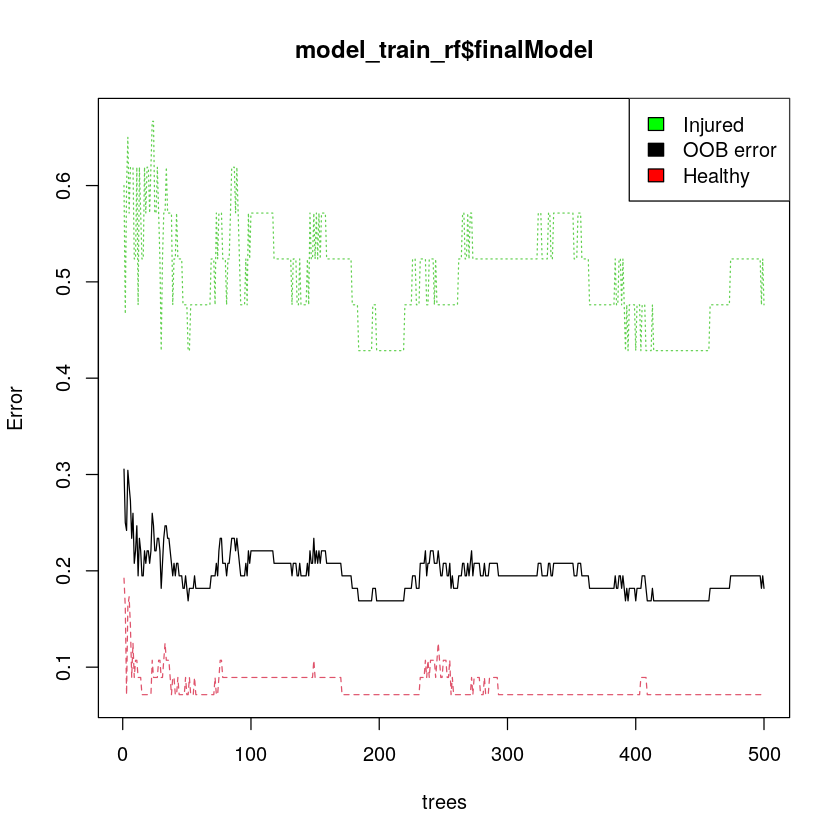

In [23]:
# View output matrix to ensure the legend identifies the correct class
tail(plot(model_train_rf$finalModel))
# Plot OOB error plot
plot(model_train_rf$finalModel)
    legend("topright",fill=c("green","black", "red"), c( "Injured", "OOB error", "Healthy"))

We can map any of these trees from the plot above but it's best to map one that has a low error value. Tree 450 looks like it has low error rates for both classes.

Before we plot anything we first need to set the final model of our random forest then we use the **forest** function to visualize the tree. 

In [24]:
final_model <- model_train_rf$finalModel$forest

Next we will run the command below to extract and structure our tree.

In [25]:
tree_func <- function(final_model, 
                      tree_num) {
  
  # Get tree by index
  tree <- randomForest::getTree(final_model, 
                                k = tree_num, 
                                labelVar = TRUE) %>%
    tibble::rownames_to_column() %>%
    # Make leaf split points to NA, so the 0s won't get plotted
    mutate(`split point` = ifelse(is.na(prediction), `split point`, NA))
  
  # Prepare data frame for graph
  graph_frame <- data.frame(from = rep(tree$rowname, 2),
                            to = c(tree$`left daughter`, tree$`right daughter`))
  
  # Convert to graph and delete the last node that we don't want to plot
  graph <- graph_from_data_frame(graph_frame) %>%
    delete_vertices("0")
  
  # Set node labels
  V(graph)$node_label <- gsub("_", " ", as.character(tree$`split var`))
  V(graph)$leaf_label <- as.character(tree$prediction)
  V(graph)$split <- as.character(round(tree$`split point`, digits = 2))
  
  # Plot
  plot <- ggraph(graph, 'dendrogram') + 
    theme_bw() +
    geom_edge_link() +
    geom_node_point() +
    geom_node_text(aes(label = node_label), na.rm = TRUE, repel = TRUE) +
    geom_node_label(aes(label = split), vjust = 2.5, na.rm = TRUE, fill = "white") +
    geom_node_label(aes(label = leaf_label, fill = leaf_label), na.rm = TRUE, 
                    repel = TRUE, colour = "white", fontface = "bold", show.legend = FALSE) +
    theme(panel.grid.minor = element_blank(),
          panel.grid.major = element_blank(),
          panel.background = element_blank(),
          plot.background = element_rect(fill = "white"),
          panel.border = element_blank(),
          axis.line = element_blank(),
          axis.text.x = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks = element_blank(),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          plot.title = element_text(size = 18))
  
  print(plot)
}

Here we are setting the tree number to the number we decided before and voila! 

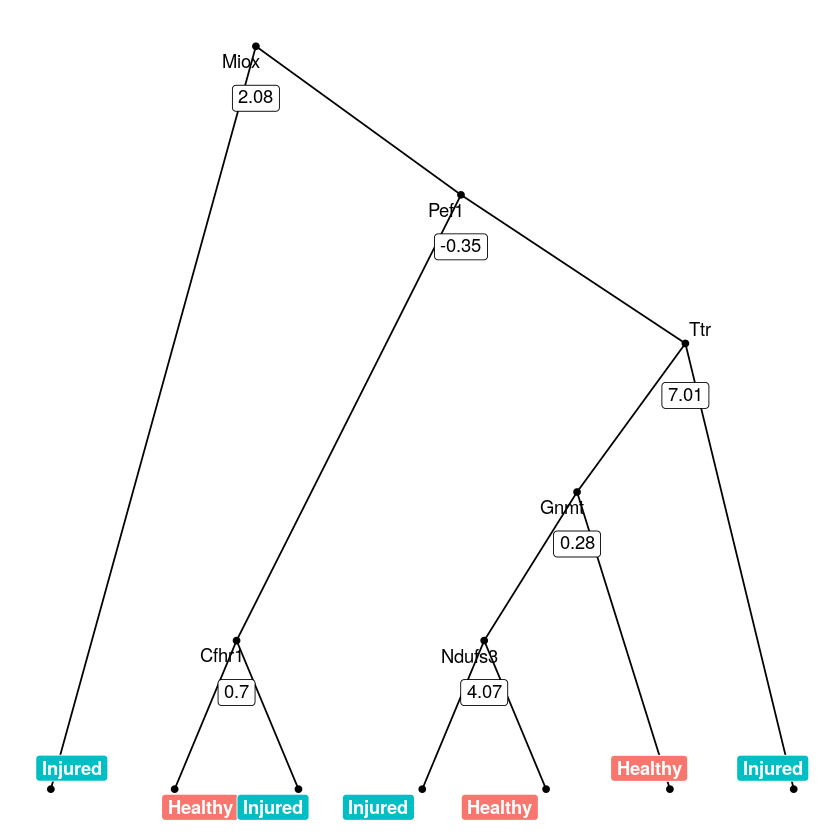

In [26]:
tree_num=450 # Tree number
suppressWarnings(tree_func(final_model =  model_train_rf$finalModel, tree_num)) #displaying the plot

#### Random Forest Testing

In [27]:
# Testing - Returns Predictions
model_test_rf <- predict(object = model_train_rf,
          newdata = testing)
# Testing - Returns Probabilities used in ROC/AUC curves
model_test_probs_rf <- predict(object = model_train_rf,
          newdata = testing, type = "prob")


# Print confusion matrix  
confusionMatrix(data = model_test_rf,
                  reference = testing$D,
                  positive = "Injured")

Confusion Matrix and Statistics

          Reference
Prediction Healthy Injured
   Healthy      13       4
   Injured       1       1
                                         
               Accuracy : 0.7368         
                 95% CI : (0.488, 0.9085)
    No Information Rate : 0.7368         
    P-Value [Acc > NIR] : 0.6173         
                                         
                  Kappa : 0.1593         
                                         
 Mcnemar's Test P-Value : 0.3711         
                                         
            Sensitivity : 0.20000        
            Specificity : 0.92857        
         Pos Pred Value : 0.50000        
         Neg Pred Value : 0.76471        
             Prevalence : 0.26316        
         Detection Rate : 0.05263        
   Detection Prevalence : 0.10526        
      Balanced Accuracy : 0.56429        
                                         
       'Positive' Class : Injured        
                          

Looking at the confusion matrix our random forest model was able to predict one true positive for injured samples and has a accuracy of 73.7%.

---

## GBM Model
<b>Gradient Boosting Machines (GBM)</b> are similar to random forests in that they both consist of hundreds of decision trees. The difference between the two is that GBM models create one tree at a time so that each tree can build on each other by looking at the previous one and learning where the errors lie, leading to the next tree having better accuracy with its prediction. As we mentioned before, random forests create trees individually by randomly selecting which features the tree should contain then asses all trees together to see how to get the higher accuracy rate. 

We are using **carets** default for tuning our GBM model.

#### GBM Training 

,n.trees,interaction.depth,shrinkage,n.minobsinnode
,<dbl>,<int>,<dbl>,<dbl>
5,100,2,0.1,10


Stochastic Gradient Boosting 

77 samples
30 predictors
 2 classes: 'Healthy', 'Injured' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 69, 70, 69, 70, 68, 69, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  Accuracy   Kappa    
  1                   50      0.8195040  0.4965785
  1                  100      0.8242857  0.5262699
  1                  150      0.8200000  0.5127543
  2                   50      0.8083532  0.4734702
  2                  100      0.8431151  0.5732119
  2                  150      0.8406151  0.5727201
  3                   50      0.8142460  0.4903860
  3                  100      0.8412500  0.5781005
  3                  150      0.8378968  0.5724845

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a value of 10
Accuracy was used to select the optimal model using the largest value.
The final values

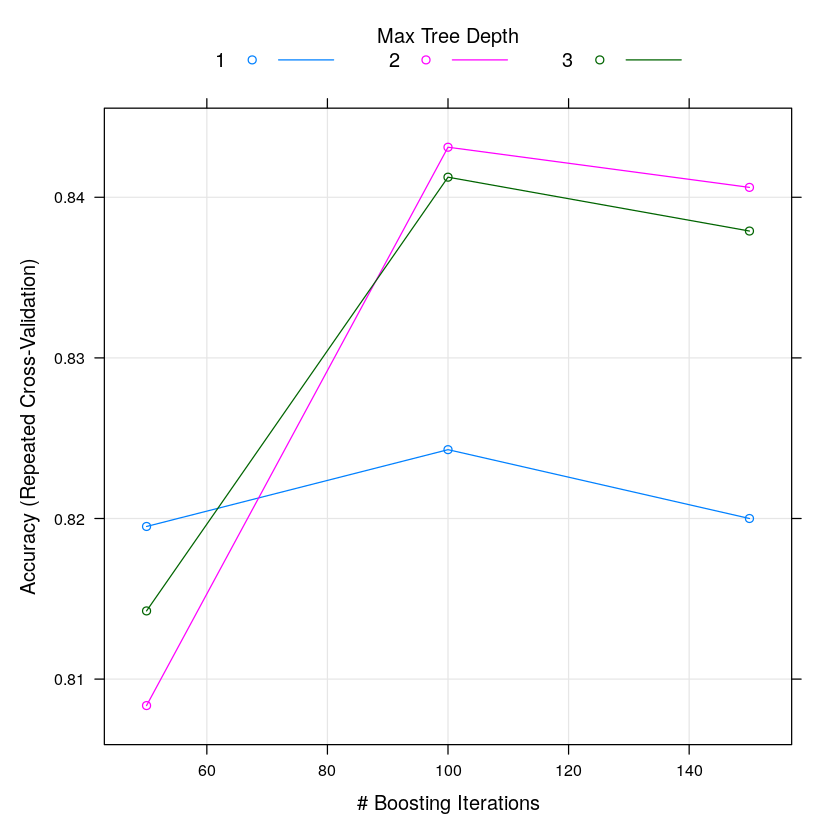

In [28]:
# Set seed so stats don't change every time this analysis is run
set.seed(156)

# Set up the training procedure or train control object, repeated Cross-Validation, that you'll refer to later in the training model
# Below you'll see we chose to do 10-fold cross-validation repeated 3 times 

train_control_gbm <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           ## Repeated ten times
                           repeats = 10)

# Fit the model 
model_train_gbm <- train(D ~ ., data = training, 
                 method = "gbm", 
                 trControl = train_control_gbm,
                 ## This last option is actually one
                 ## for gbm() that passes through
                 verbose = FALSE)

# View the model
plot(model_train_gbm)

# Show best tuning parameter from all the ones we tested
# Print the best tuning parameter interaction.depth that maximizes model accuracy
model_train_gbm$bestTune

# Show the model 
model_train_gbm

We can see that tuning GBM has four factors instead of one compared to the other models. 

- **n.trees** - Number of iterations
- **interaction.depth** - How complex the tree should be
- **shrinkage** - How quickly the model can adapt to get a lower error rate each time a tree is created
- **n.minobsinnode** - The minimum number of observations in each node this can limit the number of times the nodes can split.

#### GBM Testing 

In [29]:
# Testing
model_test_gbm <- predict(object = model_train_gbm,
          newdata = testing)

model_test_probs_gbm <- predict(object = model_train_gbm,
          newdata = testing, type = "prob")

# Print confusion matrix  
confusionMatrix(data = model_test_gbm,
                  reference = testing$D,
                  positive = "Injured")

Confusion Matrix and Statistics

          Reference
Prediction Healthy Injured
   Healthy      14       3
   Injured       0       2
                                          
               Accuracy : 0.8421          
                 95% CI : (0.6042, 0.9662)
    No Information Rate : 0.7368          
    P-Value [Acc > NIR] : 0.2227          
                                          
                  Kappa : 0.4956          
                                          
 Mcnemar's Test P-Value : 0.2482          
                                          
            Sensitivity : 0.4000          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.8235          
             Prevalence : 0.2632          
         Detection Rate : 0.1053          
   Detection Prevalence : 0.1053          
      Balanced Accuracy : 0.7000          
                                          
       'Positive' Class : Injured         
      

Our GBM model was able to predict two true positive injured sample with a 84% accuracy.

---

## SVM Model

<b>Support Vector Machine (SVM)</b> models are similar to decision trees in the sense that they are regularly used for classification problems where the data is sparse and work well when looking at two classes. Classification is performed by finding the hyper-plane that best differentiates between the two classes. For SVM we are using the **svmLinear** method from the **caret** package.

The hyperparameter to tune for SVM models is the regularization parameter (C).  This parameter adds a penalty every time an extreme parameter creates overfitting, which is usually related to large C values.  This is why it's better to set a range of small values to tune your model. 

#### SVM Training 

,C
,<dbl>
7,1.8


Support Vector Machines with Linear Kernel 

77 samples
30 predictors
 2 classes: 'Healthy', 'Injured' 

Pre-processing: centered (30), scaled (30) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 69, 70, 70, 69, 69, 70, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.25  0.7920635  0.3783619
  0.40  0.7710979  0.3415057
  0.50  0.7664683  0.3417213
  0.60  0.7825397  0.3814022
  1.00  0.7658730  0.3347168
  1.20  0.7920635  0.4157646
  1.80  0.7974206  0.4258953
  2.00  0.7963624  0.4332821

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was C = 1.8.

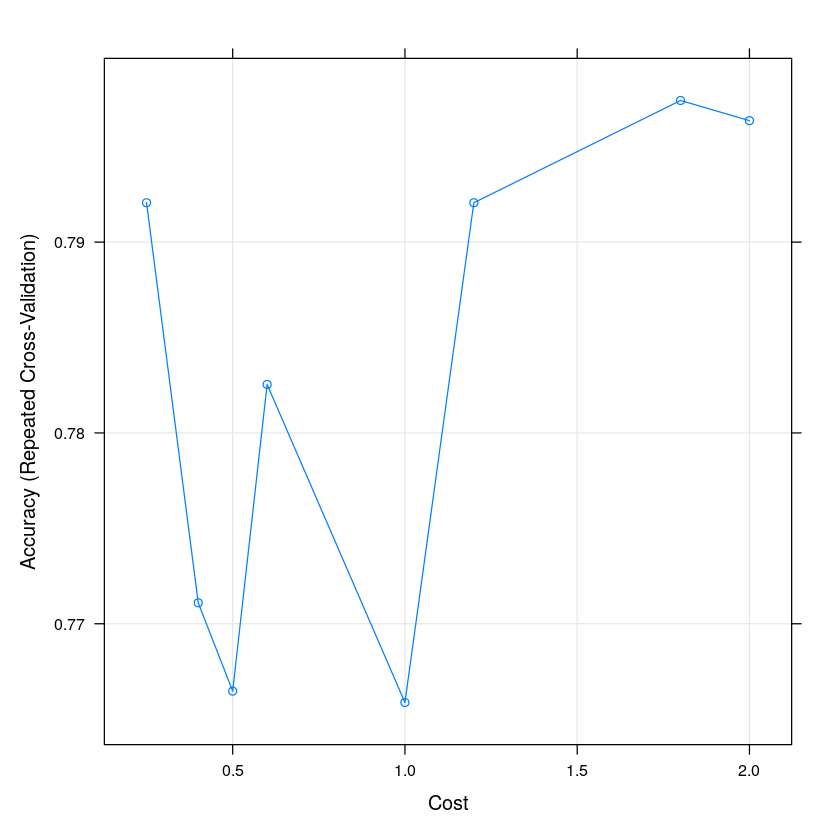

In [30]:
# Set seed so stats don't change every time this analysis is run
set.seed(2019)

# SELECT TUNING PARAMETERS
# The major tuning parameter for the SVM Linear model is Cost. It essentially imposes a penalty to the model for making an error. 
# The higher the value of C, the less likely it is that the SVM algorithm will misclassify a point.

# Make a list of cost penalty values you'de like to assess
costs_svm <- c(0.25, 0.4, 0.5, 0.6, 1, 1.2, 1.8,2.0)

# Save parameters in tune grid object that you'll refer to later in the training model
# To skip the step above and generate a list you could use: tune_grid_svm <- expand.grid(C = seq(0, 4, length = 20))
tune_grid_svm <- expand.grid(C = costs_svm)

# Set up train control object, k-fold Cross-Validation, that you'll refer to later in the training model
train_control_svm <- trainControl(method="repeatedcv", 
                                  number=10, 
                                  repeats=3,
                                  savePredictions = TRUE,
                                  classProbs = TRUE)

# Fit the model 
model_train_svm <- train(D~., 
              data = training, 
              method = "svmLinear", 
              tuneGrid = tune_grid_svm,
              trControl = train_control_svm,  
              preProcess = c("center","scale"),
              metric='Accuracy')

# View the model
plot(model_train_svm)

# Show best tuning parameter from all the ones we tested
# Print the best tuning parameter C that maximizes model accuracy
model_train_svm$bestTune

# Show the model 
model_train_svm

We can see from the graph and the table that the best value for C is 1.8 and it also has the best accuracy of 79.7%.

#### SVM Testing 

In [31]:
# Testing
model_test_svm <- predict(object = model_train_svm,
          newdata = testing)

model_test_probs_svm <- predict(object = model_train_svm,
          newdata = testing, type = "prob")


# Print confusion matrix  
confusionMatrix(data = model_test_svm,
                  reference = testing$D,
                  positive = "Injured")

Confusion Matrix and Statistics

          Reference
Prediction Healthy Injured
   Healthy      13       4
   Injured       1       1
                                         
               Accuracy : 0.7368         
                 95% CI : (0.488, 0.9085)
    No Information Rate : 0.7368         
    P-Value [Acc > NIR] : 0.6173         
                                         
                  Kappa : 0.1593         
                                         
 Mcnemar's Test P-Value : 0.3711         
                                         
            Sensitivity : 0.20000        
            Specificity : 0.92857        
         Pos Pred Value : 0.50000        
         Neg Pred Value : 0.76471        
             Prevalence : 0.26316        
         Detection Rate : 0.05263        
   Detection Prevalence : 0.10526        
      Balanced Accuracy : 0.56429        
                                         
       'Positive' Class : Injured        
                          

Testing our SVM model shows that it was able to predict one true positive injured sample and has a 73.7% accuracy.

---

# Comparing Our Models With Metrics

In the previous section, we printed confusion matrices.  Here we give a deeper explanation of confusion matrices and ROC/AUC plots. 

![Workflow](images/ConfusionMatrix.png)

Above we define a confusion matrix and common metrics calculated from its components. Most are familiar with the terms true positives vs. false positives and true negatives vs. false negatives. In our case a true positive is when we are labeling or predicting an injured sample as injured whereas a false positive is when we are labeling a sample that is really healthy as injured. ROC curves plot the false positive rate against the true positive rate. True positive rate is also known as sensitivity while false positive rate = (1-specificity). The line on a ROC curve represents the ROC while the area under the curve is the AUC and is an indicator of performance. A higher AUC indicates better performance of the model. Here we are plotting all four machine learning models to compare their performances.

Setting levels: control = Healthy, case = Injured

Setting direction: controls < cases

Setting levels: control = Healthy, case = Injured

Setting direction: controls < cases



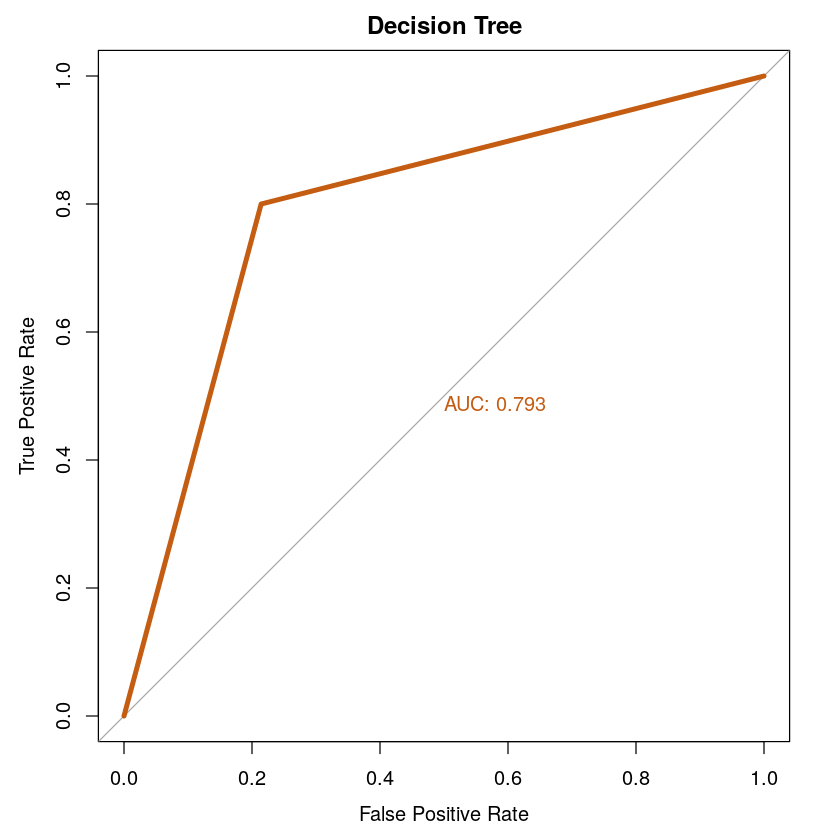

Setting levels: control = Healthy, case = Injured

Setting direction: controls < cases



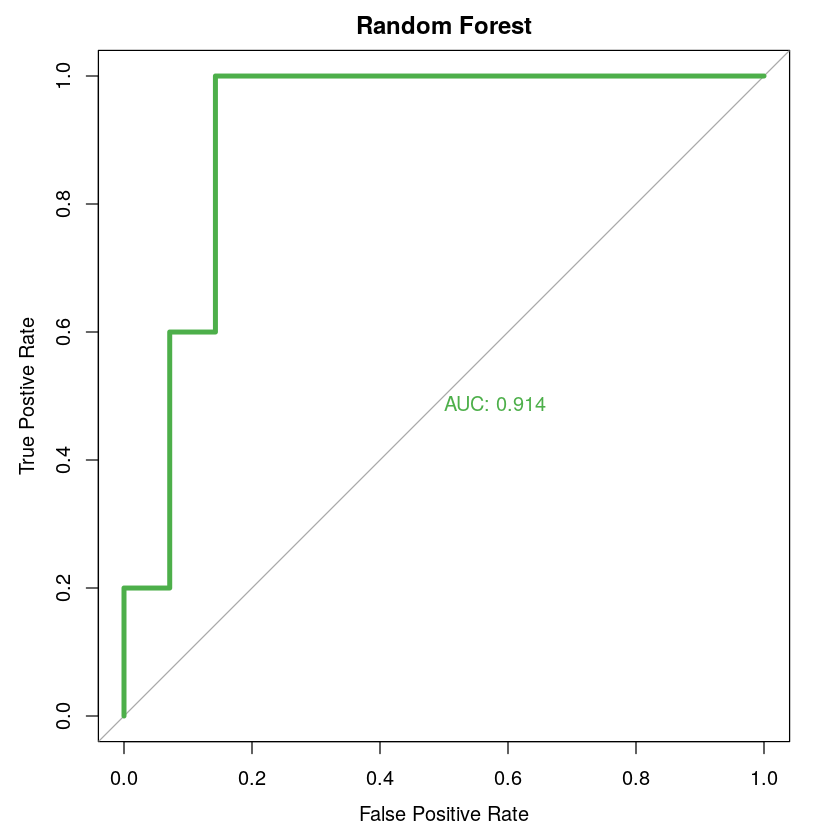

Setting levels: control = Healthy, case = Injured

Setting direction: controls < cases



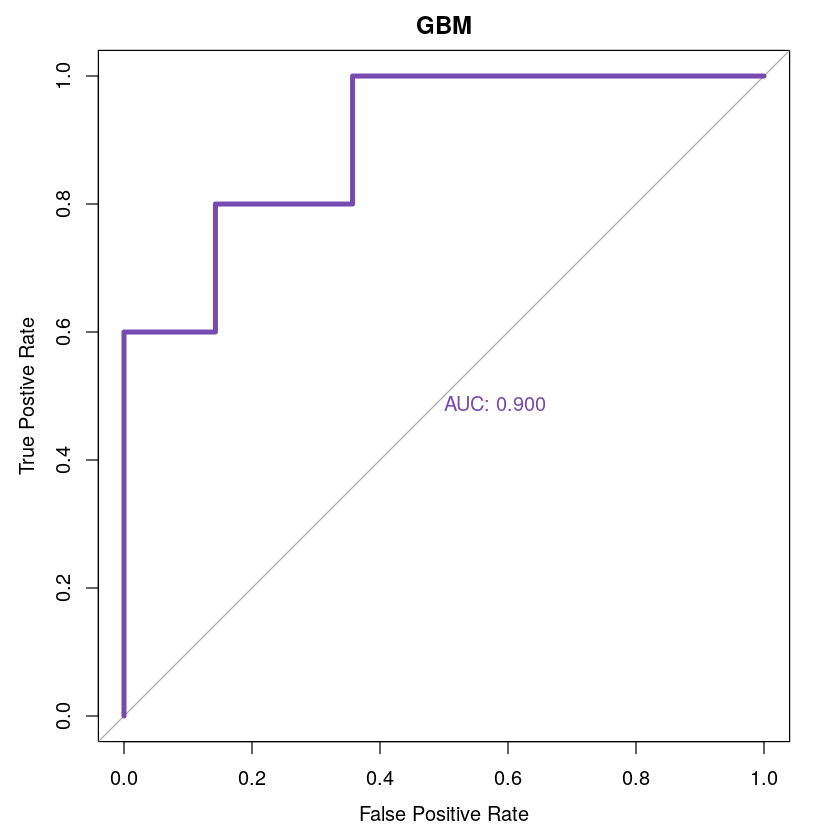

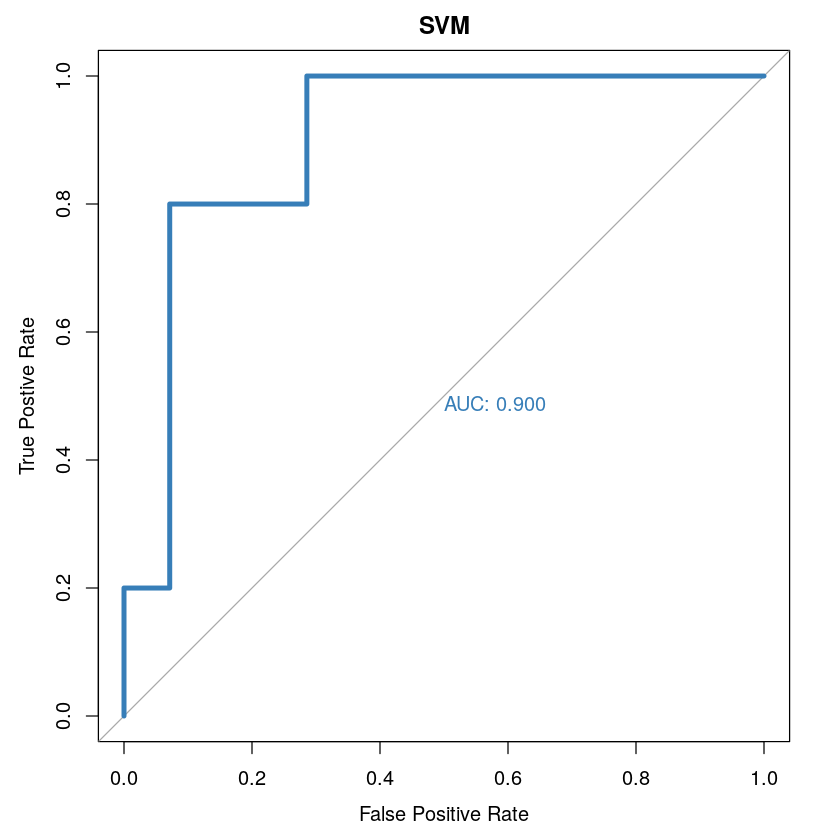

In [32]:
# Create ROC Curve for all models

pROC_DT <- roc(testing$D, predictor = model_test_probs_dt[, "Injured"], plot=TRUE, legacy.axes=TRUE, main="Decision Tree", xlab="False Positive Rate", ylab="True Postive Rate", col="#c45c12", lwd=4, print.auc=TRUE)
pROC_RF <- roc(testing$D, predictor = model_test_probs_rf[, "Injured"], plot=TRUE, legacy.axes=TRUE, main="Random Forest", xlab="False Positive Rate", ylab="True Postive Rate", col="#4daf4a", lwd=4, print.auc=TRUE)
pROC_GBM <- roc(testing$D, predictor = model_test_probs_gbm[, "Injured"], plot=TRUE, legacy.axes=TRUE,  main="GBM", xlab="False Positive Rate", ylab="True Postive Rate", col="#764aaf", lwd=4, print.auc=TRUE)
pROCSVM <- roc(testing$D, predictor = model_test_probs_svm[, "Injured"], plot=TRUE, legacy.axes=TRUE, main="SVM", xlab="False Positive Rate", ylab="True Postive Rate", col="#377eb8", lwd=4, print.auc=TRUE)

Above, we see that the model with the highest AUC was our Random Forest with a value of 0.914.

# Conclusion

Overall we can see that our Random Forest gave the best performance having been able to predict two true positive injured samples and having a AUC of 0.914. This goes to show that even though the decision tree was able to correctly predict four injured samples our graph shows it had the worst AUC out of our models. Our SVM and GBM models tied with a AUC of 0.9 though this is a high score looking at the confusion matrix after testing the models showed that they only predicted one true positive injured sample. This means that the models guessed mostly healthy because they noticed that this resulted in a lower error rate not because they truly understood how to predict injured samples, that is another reason why they were not good models to use for our dataset.

<p><span style="font-size: 30px"><b>Quizzes</b></span> <span style="float : inline;">(run the command below to display the quizzes)</span> </p>

In [33]:
IRdisplay::display_html('<iframe src="quizes/Chapter9_Quizes.html" width=100% height=450></iframe>')

---

# The End!

Thank you for completing this module!  We hope you found it helpful and encourage you to look at other modules available in the NIH sandbox.  If you have any comments on this module, please send an email to hemmecl@uri.edu (please put NOSI Biomarker Project in the subject line).

This project was funded as an administrative supplement to the Rhode Island INBRE grant P20GM10343 and would not have been possible without the help of numerous individuals.  Specifically:

- Dr. Nisanne Ghonem and her laboratory the the Department of Biomedical and Pharmaceutical Sciences, College of Pharmacy, University of Rhode Island for allowing us to use their data for this module.
- Dr. Bongsup Cho, Program Director of RI-INBRE
- Lakshmi Matukumalli, Program Director, Networks and Development Programs, NIGMS/NIH for providing this opportunity
- The teams at Google and Deloitte (Laura Beaudry, J.T. Turner, Daniel Pan, Allen Kim, Zelaikha Yosufzai, Marcia Price) who provided much needed technical support in developing this module

---

In [34]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 10 (buster)

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.3.5.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] gbm_2.1.8.1           pROC_1.18.0           mlbench_2.1-3        
 [4] igraph_1.4.1          ggraph_2.1.0          rattle_5.5.1         
 [7] bitops_1.0-7          ggpubr_0.6.0          kernlab_0.9-32       
[10] caret_6.0-94          lattice_0.20-45       factoextra_1.0.7.999 
[13] lubridate_1.9.2 